# Time series

**Prerequisites**

- [Python functions](../python_fundamentals/functions.ipynb)  
- [GroupBy](groupby.ipynb)  


**Outcomes**

- Know how pandas handles dates  
- Understand how to parse strings into `datetime` objects  
- Know how to write dates as custom formatted strings  
- Be able to access day, month, year, etc. for a `DateTimeIndex` and
  a column with `dtype` `datetime`  
- Understand both rolling and re-sampling operations and the difference
  between the two  


**Data**

- Bitcoin to USD exchange rates from March 2014 to the present  

## Outline

- [Time series](#Time-series)  
  - [Intro](#Intro)  
  - [Parsing Strings as Dates](#Parsing-Strings-as-Dates)  
  - [Date Formatting](#Date-Formatting)  
  - [Extracting Data](#Extracting-Data)  
  - [Accessing Date Properties](#Accessing-Date-Properties)  
  - [Leads and Lags: `df.shift`](#Leads-and-Lags:-`df.shift`)  
  - [Rolling Computations: `.rolling`](#Rolling-Computations:-`.rolling`)  
  - [Changing Frequencies: `.resample`](#Changing-Frequencies:-`.resample`)  
  - [Optional: API keys](#Optional:-API-keys)  
  - [Exercises](#Exercises)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wallstreet import Stock
import qeds

# see section on API keys at end of lecture!
quandl.ApiConfig.api_key = os.environ.get("QUANDL_AUTH", "Dn6BtVoBhzuKTuyo6hbp")
start_date = "2014-05-01"

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Intro

pandas has extensive support for handling dates and times.

We will loosely refer to data with date or time information as time
series data.

In this lecture, we will cover the most useful parts of pandas’ time
series functionality.

Among these topics are:

- Parsing strings as dates  
- Writing `datetime` objects as (inverse operation of previous point)  
- Extracting data from a DataFrame or Series with date information in
  the index  
- Shifting data through time (taking leads or lags)  
- Re-sampling data to a different frequency and rolling operations  


However, even more than with previous topics, we will skip a lot of the
functionality pandas offers, and we urge you to refer to the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
for more information.

## Parsing Strings as Dates

When working with time series data, we almost always receive the data
with dates encoded as strings.

Hopefully, the date strings follow a structured format or pattern.

One common pattern is `YYYY-MM-DD`: 4 numbers for the year, 2 for the
month, and 2 for the day with each section separated by a `-`.

For example, we write Christmas day 2017 in this format as

In [2]:
christmas_str = "2017-12-25"

To convert a string into a time-aware object, we use the
`pd.to_datetime` function.

In [3]:
christmas = pd.to_datetime(christmas_str)
print("The type of christmas is", type(christmas))
christmas

The type of christmas is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2017-12-25 00:00:00')

The `pd.to_datetime` function is pretty smart at guessing the format
of the date…

In [4]:
for date in ["December 25, 2017", "Dec. 25, 2017",
             "Monday, Dec. 25, 2017", "25 Dec. 2017", "25th Dec. 2017"]:
    print("pandas interprets {} as {}".format(date, pd.to_datetime(date)))

pandas interprets December 25, 2017 as 2017-12-25 00:00:00
pandas interprets Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets Monday, Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets 25 Dec. 2017 as 2017-12-25 00:00:00
pandas interprets 25th Dec. 2017 as 2017-12-25 00:00:00


However, sometimes we will need to give pandas a hint.

For example, that same time (midnight on Christmas) would be reported on
an Amazon transaction report as

In [5]:
christmas_amzn = "2017-12-25T00:00:00+ 00 :00"

If we try to pass this to `pd.to_datetime`, it will fail.

```python
pd.to_datetime(christmas_amzn)
```


To parse a date with this format, we need to specify the `format`
argument for `pd.to_datetime`.

In [6]:
amzn_strftime = "%Y-%m-%dT%H:%M:%S+ 00 :00"
pd.to_datetime(christmas_amzn, format=amzn_strftime)

Timestamp('2017-12-25 00:00:00')

Can you guess what `amzn_strftime` represents?

Let’s take a closer look at `amzn_strftime` and `christmas_amzn`.

In [7]:
print(amzn_strftime)
print(christmas_amzn)

%Y-%m-%dT%H:%M:%S+ 00 :00
2017-12-25T00:00:00+ 00 :00


Notice that both of the strings have a similar form, but that instead of actual numerical values, `amzn_strftime` has *placeholders*.

Specifically, anywhere the `%` shows up is a signal to the `pd.to_datetime`
function that it is where relevant information is stored.

For example, the `%Y` is a stand-in for a four digit year, `%m` is
for 2 a digit month, and so on…

The official [Python
documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) contains a complete list of possible `%`something patterns that are accepted
in the `format` argument.


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)

### Multiple Dates

If we have dates in a Series (e.g. column of DataFrame) or a list, we
can pass the entire collection to `pd.to_datetime` and get a
collection of dates back.

We’ll just show an example of that here as the mechanics are the same as
a single date.

In [8]:
pd.to_datetime(["2017-12-25", "2017-12-31"])

DatetimeIndex(['2017-12-25', '2017-12-31'], dtype='datetime64[ns]', freq=None)

## Date Formatting

We can use the `%`pattern format to have pandas write `datetime`
objects as specially formatted strings using the `strftime` (string
format time) method.

For example,

In [9]:
christmas.strftime("We love %A %B %d (also written %c)")

'We love Monday December 25 (also written Mon Dec 25 00:00:00 2017)'

## Extracting Data

When the index of a DataFrame has date information and pandas
recognizes the values as `datetime` values, we can leverage some
convenient indexing features for extracting data.

The flexibility of these features is best understood through example,
so let’s load up some data and take a look.

___

Below we are using Quandl an API that allows us to get a wide range of data for free [here is a list of free data sets](https://www.quandl.com/search?filters=%5B%22Free%22%5D&page=3)

There is a wide range of different API for Python. We will later discuss a few more that we will use

In [54]:
s = Stock('GME')

gme= s.historical(days_back=3000, frequency='d')
gme.set_index('Date',inplace=True)
gme.info()
gme.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2013-02-25 to 2021-05-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2071 non-null   float64
 1   High       2071 non-null   float64
 2   Low        2071 non-null   float64
 3   Close      2071 non-null   float64
 4   Adj Close  2071 non-null   float64
 5   Volume     2071 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 113.3 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,25.090000,25.200001,24.610001,24.610001,17.195938,1538700
2013-02-26,24.770000,25.219999,23.780001,24.790001,17.321712,2680500
2013-02-27,24.709999,25.389999,24.629999,25.240000,17.636143,3451800
2013-02-28,25.320000,25.660000,25.049999,25.059999,17.510372,2698600
2013-03-01,24.639999,24.850000,23.950001,24.049999,16.991102,3525900


Here, we have the Bitcoin (BTC) to US dollar (USD) exchange rate from
March 2014 until today.

Notice that the type of index is `DateTimeIndex`.

This is the key that enables things like…

Extracting all data for the year 2015 by passing `"2015"` to `.loc`.

In [55]:
gme.loc["2015"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,34.060001,34.160000,33.250000,33.799999,25.155836,1612700
2015-01-05,33.520000,34.880001,33.330002,34.720001,25.840551,4934900
2015-01-06,35.169998,36.029999,33.520000,33.689999,25.073961,4885100
2015-01-07,34.290001,34.680000,32.980000,33.299999,24.783703,2558300
2015-01-08,33.599998,34.169998,33.320000,33.689999,25.073961,4547400
...,...,...,...,...,...,...
2015-12-24,28.620001,28.799999,28.280001,28.370001,21.895107,869000
2015-12-28,28.370001,28.940001,28.139999,28.469999,21.972286,2325400
2015-12-29,28.620001,28.799999,28.330000,28.430000,21.941414,2040400


We can also narrow down to specific months.

In [58]:
# By month's name
gme.loc["August 2017"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-01,21.690001,21.690001,21.139999,21.360001,17.939491,3059100
2017-08-02,21.320000,21.620001,21.270000,21.379999,17.956287,1116100
2017-08-03,21.320000,21.820000,21.320000,21.660000,18.191450,1047900
2017-08-04,21.780001,22.110001,21.690001,21.930000,18.418217,1136100
2017-08-07,21.940001,22.260000,21.830000,22.170000,18.619781,1277600
2017-08-08,22.200001,22.370001,21.900000,21.940001,18.426615,1422500
2017-08-09,21.750000,22.120001,21.620001,22.080000,18.544193,1503500
2017-08-10,21.910000,21.910000,21.459999,21.469999,18.031876,1521300
2017-08-11,21.240000,21.830000,21.070000,21.760000,18.275438,1619300


In [59]:
# By month's number
gme.loc["08/2017"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-01,21.690001,21.690001,21.139999,21.360001,17.939491,3059100
2017-08-02,21.320000,21.620001,21.270000,21.379999,17.956287,1116100
2017-08-03,21.320000,21.820000,21.320000,21.660000,18.191450,1047900
2017-08-04,21.780001,22.110001,21.690001,21.930000,18.418217,1136100
2017-08-07,21.940001,22.260000,21.830000,22.170000,18.619781,1277600
2017-08-08,22.200001,22.370001,21.900000,21.940001,18.426615,1422500
2017-08-09,21.750000,22.120001,21.620001,22.080000,18.544193,1503500
2017-08-10,21.910000,21.910000,21.459999,21.469999,18.031876,1521300
2017-08-11,21.240000,21.830000,21.070000,21.760000,18.275438,1619300


Or even a day…

In [60]:
# By date name
gme.loc["August 1, 2017"]

Open         2.169000e+01
High         2.169000e+01
Low          2.114000e+01
Close        2.136000e+01
Adj Close    1.793949e+01
Volume       3.059100e+06
Name: 2017-08-01 00:00:00, dtype: float64

In [61]:
# By date number
gme.loc["08-01-2017"]

Open         2.169000e+01
High         2.169000e+01
Low          2.114000e+01
Close        2.136000e+01
Adj Close    1.793949e+01
Volume       3.059100e+06
Name: 2017-08-01 00:00:00, dtype: float64

What can we pass as the `.loc` argument when we have a
`DateTimeIndex`?

Anything that can be converted to a `datetime` using
`pd.to_datetime`, *without* having to specify the format argument.

When that condition holds, pandas will return *all* rows whose date in
the index “belong” to that date or period.

We can also use the range shorthand notation to give a start and end
date for selection.

In [62]:
gme.loc["April 1, 2015":"April 10, 2015"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-01,37.860001,38.500000,37.330002,37.779999,28.375410,2464900
2015-04-02,38.060001,38.810001,37.880001,38.200001,28.690855,1172600
2015-04-06,38.000000,38.389999,37.680000,38.369999,28.818537,1483900
2015-04-07,38.369999,38.500000,37.919998,37.980000,28.525623,1332100
2015-04-08,37.799999,38.779999,37.740002,38.709999,29.073900,1649200
2015-04-09,38.759998,40.000000,38.349998,39.990002,30.035278,1911600
2015-04-10,40.180000,40.410000,39.560001,40.400002,30.343212,1269000



<a id='exercise-2'></a>
> See exercise 3 in the [*exercise list*](#exerciselist-0)

## Accessing Date Properties

Sometimes, we would like to directly access a part of the date/time.

If our date/time information is in the index, we can to `df.index.XX`
where `XX` is replaced by `year`, `month`, or whatever we would
like to access.

In [63]:
gme.index.year

Int64Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=2071)

In [64]:
gme.index.day

Int64Index([25, 26, 27, 28,  1,  4,  5,  6,  7,  8,
            ...
             3,  4,  5,  6,  7, 10, 11, 12, 13, 14],
           dtype='int64', name='Date', length=2071)

We can also do the same if the date/time information is stored in a
column, but we have to use a slightly different syntax.

```python
df["column_name"].dt.XX
```


In [65]:
gme_date_column = gme.reset_index()
gme_date_column.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-02-25,25.090000,25.200001,24.610001,24.610001,17.195938,1538700
1,2013-02-26,24.770000,25.219999,23.780001,24.790001,17.321712,2680500
2,2013-02-27,24.709999,25.389999,24.629999,25.240000,17.636143,3451800
3,2013-02-28,25.320000,25.660000,25.049999,25.059999,17.510372,2698600
4,2013-03-01,24.639999,24.850000,23.950001,24.049999,16.991102,3525900


In [66]:
gme_date_column["Date"].dt.year.head()

0    2013
1    2013
2    2013
3    2013
4    2013
Name: Date, dtype: int64

In [67]:
gme_date_column["Date"].dt.month.head()

0    2
1    2
2    2
3    2
4    3
Name: Date, dtype: int64

## Leads and Lags: `df.shift`

When doing time series analysis, we often want to compare data at one
date against data at another date.

pandas can help us with this if we leverage the `shift` method.

Without any additional arguments, `shift()` will move all data
*forward* one period, filling the first row with missing data.

In [68]:
# so we can see the result of shift clearly
gme.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,25.090000,25.200001,24.610001,24.610001,17.195938,1538700
2013-02-26,24.770000,25.219999,23.780001,24.790001,17.321712,2680500
2013-02-27,24.709999,25.389999,24.629999,25.240000,17.636143,3451800
2013-02-28,25.320000,25.660000,25.049999,25.059999,17.510372,2698600
2013-03-01,24.639999,24.850000,23.950001,24.049999,16.991102,3525900


In [69]:
gme.shift().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-26,25.090000,25.200001,24.610001,24.610001,17.195938,1538700.0
2013-02-27,24.770000,25.219999,23.780001,24.790001,17.321712,2680500.0
2013-02-28,24.709999,25.389999,24.629999,25.240000,17.636143,3451800.0
2013-03-01,25.320000,25.660000,25.049999,25.059999,17.510372,2698600.0


We can use this to compute the percent change from one day to the next.
(Quiz: Why does that work? Remember how pandas uses the index to *align*
data.)

In [70]:
((gme.Close - gme.Close.shift()) / gme.Close.shift()).head()

Date
2013-02-25         NaN
2013-02-26    0.007314
2013-02-27    0.018152
2013-02-28   -0.007132
2013-03-01   -0.040303
Name: Close, dtype: float64

Setting the first argument to `n` tells pandas to shift the data down
`n` rows (apply an `n` period lag).

In [71]:
gme.shift(3).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-26,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-27,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,25.09,25.200001,24.610001,24.610001,17.195938,1538700.0
2013-03-01,24.77,25.219999,23.780001,24.790001,17.321712,2680500.0


A negative value will shift the data *up* or apply a lead.

In [72]:
gme.shift(-2).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,24.709999,25.389999,24.629999,25.240000,17.636143,3451800.0
2013-02-26,25.320000,25.660000,25.049999,25.059999,17.510372,2698600.0
2013-02-27,24.639999,24.850000,23.950001,24.049999,16.991102,3525900.0
2013-02-28,23.959999,24.070000,23.360001,23.540001,16.630795,3299800.0
2013-03-01,23.780001,24.360001,23.670000,24.299999,17.167728,3472000.0


In [73]:
gme.shift(-2).tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-10,145.699997,150.500000,142.229996,144.789993,144.789993,2731500.0
2021-05-11,147.440002,169.949997,146.429993,164.500000,164.500000,8860800.0
2021-05-12,147.440002,166.429993,156.229996,163.884995,163.884995,2270087.0
2021-05-13,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-14,NaN,NaN,NaN,NaN,NaN,NaN



<a id='exercise-3'></a>
> See exercise 4 in the [*exercise list*](#exerciselist-0)

## Rolling Computations: `.rolling`

pandas has facilities that enable easy computation of *rolling
statistics*.

These are best understood by example, so we will dive right in.

In [74]:
# first take only the first 6 rows so we can easily see what is going on
gme_small = gme.head(6)
gme_small

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,25.090000,25.200001,24.610001,24.610001,17.195938,1538700
2013-02-26,24.770000,25.219999,23.780001,24.790001,17.321712,2680500
2013-02-27,24.709999,25.389999,24.629999,25.240000,17.636143,3451800
2013-02-28,25.320000,25.660000,25.049999,25.059999,17.510372,2698600
2013-03-01,24.639999,24.850000,23.950001,24.049999,16.991102,3525900
2013-03-04,23.959999,24.070000,23.360001,23.540001,16.630795,3299800


Below, we compute the 2 day moving average (for all columns).

In [75]:
gme_small.rolling("2d").mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,25.090000,25.200001,24.610001,24.610001,17.195938,1538700.0
2013-02-26,24.930000,25.210000,24.195001,24.700001,17.258825,2109600.0
2013-02-27,24.739999,25.304999,24.205000,25.015000,17.478928,3066150.0
2013-02-28,25.015000,25.524999,24.839999,25.149999,17.573258,3075200.0
2013-03-01,24.979999,25.255000,24.500000,24.554999,17.250737,3112250.0
2013-03-04,23.959999,24.070000,23.360001,23.540001,16.630795,3299800.0


To do this operation, pandas starts at each row (date) then looks
*backwards* the specified number of periods (here 2 days) and then
applies some aggregation function (`mean`) on all the data in that
window.

If pandas cannot look back the full length of the window (e.g. when
working on the first row), it fills as much of the window as possible
and then does the operation. Notice that the value at 2013-02-25 is
the same in both DataFrames.

Below, we see a visual depiction of the rolling maximum on a 21 day
window for the whole dataset.

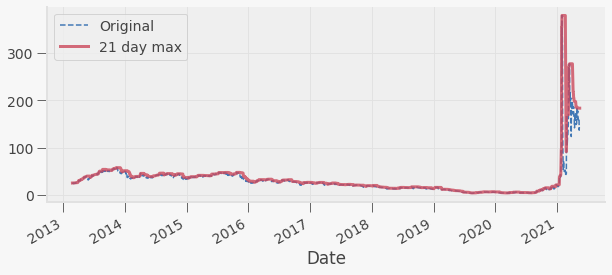

In [76]:
fig, ax = plt.subplots(figsize=(10, 4))
gme["Open"].plot(ax=ax, linestyle="--", alpha=0.8)
gme.rolling("21d").max()["Open"].plot(ax=ax, alpha=0.8, linewidth=3)
ax.legend(["Original", "21 day max"])

We can also ask pandas to `apply` custom functions, similar to what we
saw when studying GroupBy.

In [77]:
def is_volatile(x):
    "Returns a 1 if the variance is greater than 1, otherwise returns 0"
    if x.var() > 1.0:
        return 1.0
    else:
        return 0.0

In [78]:
gme_small.rolling("2d").apply(is_volatile)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-25,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-26,0.0,0.0,0.0,0.0,0.0,1.0
2013-02-27,0.0,0.0,0.0,0.0,0.0,1.0
2013-02-28,0.0,0.0,0.0,0.0,0.0,1.0
2013-03-01,0.0,0.0,0.0,0.0,0.0,1.0
2013-03-04,0.0,0.0,0.0,0.0,0.0,0.0



<a id='exercise-4'></a>
> See exercise 5 in the [*exercise list*](#exerciselist-0)


To make the optimal decision, we need to know the maximum
difference between the close price at the end of the window and the open
price at the start of the window.


<a id='exercise-5'></a>
> See exercise 6 in the [*exercise list*](#exerciselist-0)

## Changing Frequencies: `.resample` (Opt)

In addition to computing rolling statistics, we can also change the
frequency of the data.

For example, instead of a monthly moving average, suppose that we wanted
to compute the average *within* each calendar month.

We will use the `resample` method to do this.

Below are some examples.

In [79]:
# business quarter
gme.resample("BQ").mean()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-29,25.094583,25.565417,24.737500,25.247083,17.804623,2.547904e+06
2013-06-28,35.254844,36.019219,34.700781,35.398437,25.081355,4.000192e+06
2013-09-30,47.824062,48.547031,47.145469,47.809063,34.124808,2.185230e+06
2013-12-31,51.333750,51.968750,50.496250,51.277344,36.793633,2.739705e+06
2014-03-31,38.387869,39.046885,37.721147,38.420984,27.729402,4.613946e+06
2014-06-30,39.208889,39.785555,38.583651,39.152540,28.531126,2.880822e+06
2014-09-30,42.605938,43.127188,41.989375,42.523750,31.254489,2.490878e+06
2014-12-31,38.776094,39.396875,38.087969,38.687188,28.659051,3.475708e+06
2015-03-31,37.669344,38.290000,36.985246,37.606721,28.047138,2.333562e+06


Note that unlike with `rolling`, a single number is returned for
each column for each quarter.

The `resample` method will alter the frequency of the data and the
number of rows in the result will be different from the number of rows
in the input.

On the other hand, with `rolling`, the size and frequency of the result
are the same as the input.

We can sample at other frequencies and aggregate with multiple aggregations
function at once.

In [80]:
# multiple functions at 2 start-of-quarter frequency
gme.resample("2BQS").agg(["min", "max"])

Open                   High                    Low  \
                  min         max        min         max        min   
Date                                                                  
2013-01-01  23.780001   41.410000  24.070000   42.840000  23.360001   
2013-07-01  42.000000   57.680000  42.340000   57.740002  41.660000   
2014-01-01  33.669998   49.709999  34.380001   50.000000  33.099998   
2014-07-01  32.110001   46.060001  32.730000   46.590000  31.809999   
2015-01-01  32.549999   44.580002  33.709999   45.500000  31.690001   
2015-07-01  28.370001   47.619999  28.799999   47.830002  27.900000   
2016-01-01  25.059999   33.200001  25.450001   33.720001  24.330000   
2016-07-01  20.590000   32.130001  20.920000   32.669998  20.100000   
2017-01-02  20.330000   26.330000  20.660000   26.680000  20.240000   
2017-07-03  16.010000   22.200001  16.379999   22.370001  15.850000   
2018-01-01  12.510000   19.920000  12.750000   20.309999  12.200000   
2018-07-02  11.720000   16.980000  12.020000   17.270000  11.560000   
2019-01-01   4.980000   16.020000   5.130000   16.900000   4.710000   
2019-07-01   3.250000    6.650000   3.360000    6.920000   3.150000   
2020-01-01   2.850000    6.210000   2.940000    6.470000   2.570000   
2020-07-01   3.900000   21.309999   4.050000   22.350000   3.770000   
2021-01-01  17.340000  379.709991  18.080000  483.000000  17.080000   

                            Close              Adj Close               Volume  \
                   max        min         max        min         max      min   
Date                                                                            
2013-01-01   41.119999  23.540001   42.029999  16.630795   29.939573  1203200   
2013-07-01   56.919998  42.169998   57.590000  30.039301   41.250896   626000   
2014-01-01   49.070000  33.830002   49.650002  24.370848   35.767437  1317800   
2014-07-01   45.860001  31.920000   46.099998  23.756634   33.791782  1102800   
2015-01-01   44.160000  32.270000   44.549999  24.017122   33.735287   747200   
2015-07-01   46.900002  28.040001   47.439999  21.640425   35.923729   746100   
2016-01-01   33.099998  25.059999   33.380001  19.340549   26.056412  1264900   
2016-07-01   31.830000  20.730000   32.160000  16.610323   25.432758  1031700   
2017-01-02   26.020000  20.459999   26.520000  17.093769   21.566963  1151100   
2017-07-03   21.900000  16.000000   22.170000  13.707144   18.619781   972900   
2018-01-01   19.770000  12.460000   19.959999  11.151717   17.439156  1867000   
2018-07-02   16.620001  11.670000   17.040001  11.287046   15.660386  1289300   
2019-01-01   15.880000   5.020000   15.980000   5.020000   15.455612  1282000   
2019-07-01    6.390000   3.210000    6.680000   3.210000    6.680000  1369000   
2020-01-01    6.070000   2.800000    6.310000   2.800000    6.310000  1467600   
2020-07-01   20.350000   3.850000   20.990000   3.850000   20.990000  1330100   
2021-01-01  262.269989  17.250000  347.510010  17.250000  347.510010  1789200   

                       
                  max  
Date                   
2013-01-01   13867200  
2013-07-01   14606000  
2014-01-01   23506700  
2014-07-01   18761100  
2015-01-01    8682800  
2015-07-01   16933800  
2016-01-01   22220500  
2016-07-01   14493400  
2017-01-02   15944600  
2017-07-03   20500700  
2018-01-01   25824000  
2018-07-02   17471600  
2019-01-01   39354200  
2019-07-01   34005000  
2020-01-01   13506600  
2020-07-01   77152800  
2021-01-01  197157900

As with `groupby` and `rolling`, you can also provide custom
functions to `.resample(...).agg` and `.resample(...).apply`


<a id='exercise-6'></a>
> See exercise 7 in the [*exercise list*](#exerciselist-0)


To make the optimal decision we need to, for each month,
compute the maximum value of the close price on any day minus the open
price on the first day of the month.


<a id='exercise-7'></a>
> See exercise 8 in the [*exercise list*](#exerciselist-0)

([*back to text*](#exercise-7))